# Weather Generator

Weather data is ubiquitous and important for most daily activities. In agriculture, weather plays a preponderant role since it dictates the growth and eventual crop yield (fiber, biomass, or grain).

Air temperature and precipitation are by far the most commonly monitored variables, followed by relative humidity, wind speed and direccion, solar radiation, soil temperature, and soil moisture.

We will create a weather generator to generate daily minimum and maximum air temperature and precipitation scenarios. To understand the process we will examine long-term data for a specific location. Based on the trends we will build the weather generator.

> This weather generator is for teaching purposes only and lacks the statistical rigor of research tools. The exercise is only intended as a primer for students learning how to creating simple scripts using random modules. For more advanced tools, please visit the references section.


In [555]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [556]:
# Load sample data
df = pd.read_csv("../datasets/KS_Manhattan_6_SSW.csv")
df.head()


,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,53974,20031001,1.201,-96.61,39.1,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,53974,20031002,1.201,-96.61,39.1,18.9,2.5,10.7,11.7,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,53974,20031003,1.201,-96.61,39.1,22.6,8.1,15.4,14.8,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
3,53974,20031004,1.201,-96.61,39.1,22.6,3.8,13.2,14.0,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
4,53974,20031005,1.201,-96.61,39.1,25.0,10.6,17.8,17.3,0.0,...,-99.0,-99.0,-99.0,-99,-99,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [557]:
# Convert date string to pandas datetime format
df["LST_DATE"] = pd.to_datetime(df["LST_DATE"], format="%Y%m%d")
df["LST_DATE"].head() # CHeck our conversion.


0   2003-10-01
1   2003-10-02
2   2003-10-03
3   2003-10-04
4   2003-10-05
Name: LST_DATE, dtype: datetime64[ns]

In [559]:
# Convert missing values represented as -9999 to NaN
df[df == -9999] = np.nan


In [558]:
# Add year, month, and day of the year to summarize data in future steps.
df["YEAR"] = df["LST_DATE"].dt.year
df["MONTH"] = df["LST_DATE"].dt.month
df["DOY"] = df["LST_DATE"].dt.dayofyear


## Modeling rainfall as a Markov chain. 

This type of rainfall generators is kwnon as the Richardson-type (Richardson and Wright, 1984). The model computes the rainfall at time *t* as a function of time *t-1* in three steps. 

To be consistent with the original manuscript by Richardson and Wright, 1984 we will use the term "wet" for a day with measurable rainfall and "dry" for a day without measurable rainfall.

**Step 1**: Find if the previous (i.e. *t-1*) day was dry (no measurable rainfall) or wet (some measurable rainfall)

**Step 2**: Then compute the probability of having a rainfall event on day *t* given the condition on the previous day. So, here we need to have two different probability values, one that we will use if yesterday was dry, and another if yesterday was wet. 

- What is the probability of having a wet day if yesterday was dry? (i.e. P(W/D) )

- What is the probability of having a wet day if yesterday was wet? (i.e. P(W/W) )

As you can see if we only use two values and we are generating rainfall for a long period, then may not accurately simulate seasonal rainfall trends. TO solve this some models use Wet-Dry and Wet-Wet on a monthly basis. In this step we generate a yes/no answer. We will deal with the amount in the next step. 

**Step 3**: If as a consequence of the random process we obtain that on day *t* there is a rainfall event, then we have to compute the amount. To do this we will use a gamma distribution, which is suited to heavily skewed distributions, such as those resulting from histograms of daily rainfall. Again, here we probably want to have some parameters that describe this distribution at least on a monthly basis to capture the seasonal effects on rainfall amounts.


We will first run an example using the loaded dataset to learn how to compute the Wet-Dry and Wet-Wet probabilities for the entire year. It's important that we first learn how to compute the simplest step before moving into a more detailed characterization of the rainfall process on a monthly basis.


In [589]:
# Rainfall probability Wet-Dry and Wet-Wet
WW = []
WD = []
month_WW = []
month_WD = []

# Extract variables from DataFrame to sherten variable names
months = df["MONTH"]
rainfall = df["P_DAILY_CALC"]

for i in range(1,df.shape[0]):
    if rainfall[i-1] > 0:
        
        # Get current month
        month_WW.append(months[i])
        
        if rainfall[i] > 0:
            WW.append(1)
        else:
            WW.append(0)
    
    elif rainfall[i-1] == 0:
        
        month_WD.append(months[i])
        if rainfall[i] > 0:
            WD.append(1)
        else:
            WD.append(0)

print(sum(WW)/len(WW))
print(sum(WD)/len(WD))


0.4166666666666667
0.20590604026845638


In [590]:
# WW
df_WW = pd.DataFrame([month_WW,WW]).T
df_WW.columns = ["month","WW"]
df_WW.tail(5)


,month,WW
1315,9,0
1316,9,0
1317,9,1
1318,9,0
1319,10,1


In [591]:
# WD
df_WD = pd.DataFrame([month_WD, WD]).T
df_WD.columns = ["month","WD"]
df_WD.tail(5)


,month,WD
3720,9,0
3721,9,0
3722,10,0
3723,10,0
3724,10,1


In [592]:
monthly_WW = df_WW.groupby("month").sum()/df_WW.groupby("month").count()
monthly_WD = df_WD.groupby("month").sum()/df_WD.groupby("month").count()


In [593]:
# Create table of parameters
coeff = pd.concat([monthly_WW, monthly_WD], axis=1)
coeff


,WW,WD
month,,
1,0.338028,0.141176
2,0.320513,0.161184
3,0.401709,0.219048
4,0.503448,0.273063
5,0.480769,0.290909
6,0.442953,0.293680
7,0.415254,0.228571
8,0.412214,0.245847
9,0.362745,0.201258


In [594]:
from scipy.stats import gamma
from scipy.optimize import curve_fit

monthly_alpha = []
monthly_scale = []
unique_months = list(range(1,13))
for m in unique_months:
    idx_month = df["MONTH"] == m
    x = df["P_DAILY_CALC"].loc[idx_month]
    x = x[~np.isnan(x)]
    x = x[x>0]
    alpha, loc, scale = gamma.fit(x, floc=0)
    monthly_alpha.append(alpha)
    monthly_scale.append(scale)


In [595]:
coeff["alpha"] = monthly_alpha
coeff["scale"] = monthly_scale
coeff.head(12)


,WW,WD,alpha,scale
month,,,,
1,0.338028,0.141176,0.748257,4.166760
2,0.320513,0.161184,0.678656,8.142081
3,0.401709,0.219048,0.632519,11.092325
4,0.503448,0.273063,0.589697,15.483557
5,0.480769,0.290909,0.630033,13.661336
6,0.442953,0.293680,0.599585,22.291664
7,0.415254,0.228571,0.677182,16.648971
8,0.412214,0.245847,0.625811,21.885339
9,0.362745,0.201258,0.585308,15.593047


Check that our gamma function can generate sound rainfall distributions. Note that the figure below is the pdf function, not the actual rainfall. The y-axis contains density information, while the x-axis contains rainfall data.

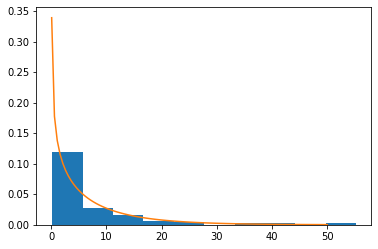

In [617]:
a,b,c = gamma.fit(x, floc=0)
plt.hist(x, density=True)
plt.plot(np.linspace(0.1,50,100), gamma.pdf(np.linspace(0.1,50,100),a,b,c))
plt.show()


Total rainfall 1038.0
Total rainfall 921.0
Total rainfall 719.0
Total rainfall 709.0
Total rainfall 705.0
Total rainfall 845.0
Total rainfall 766.0
Total rainfall 739.0
Total rainfall 884.0
Total rainfall 745.0
Total rainfall 728.0
Total rainfall 827.0
Total rainfall 1014.0
Total rainfall 905.0
Total rainfall 778.0
Total rainfall 877.0
Total rainfall 828.0
Total rainfall 710.0
Total rainfall 781.0
Total rainfall 1079.0


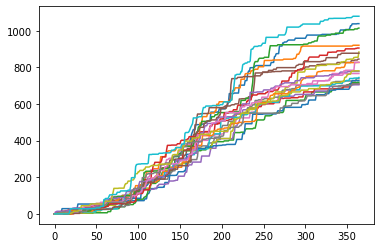

In [618]:
#def generate_rainfall(dates):
 
dates = pd.date_range("1-jan-2018","31-dec-2018",freq="D")

def rainfall_gen(dates,coeff):
    
    P = np.ones(dates.shape[0])*np.nan
    P[0] = 0

    for t in range(1,dates.shape[0]):
        month = dates.month[t]
        if P[t-1] == 0:
            if np.random.rand() > coeff["WD"][month]:
                P[t] = 0
            else:
                P[t] = gamma.rvs(coeff["alpha"][month],0,coeff["scale"][month])
                P[t] = np.round(P[t]*10)/10

        elif P[t-1] > 0:
            if np.random.rand() > coeff["WW"][month]:
                P[t] = 0
            else:
                P[t] = gamma.rvs(coeff["alpha"][month],0,coeff["scale"][month])
                P[t] = np.round(P[t]*10)/10

    P_total = P.sum()
    return P

for i in range(20):
    P = rainfall_gen(dates,coeff)
    print("Total rainfall",round(P.sum()))
    plt.plot(P.cumsum())
    
plt.show()

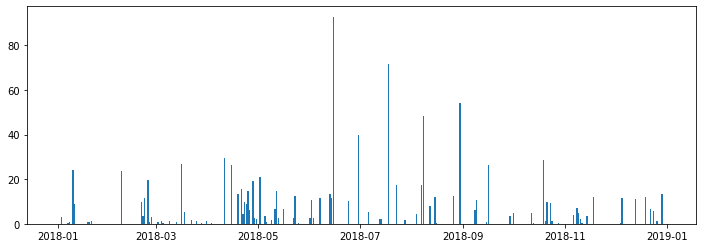

In [615]:
plt.figure(figsize=(12,4))
plt.bar(dates,P)
plt.show()

## Observe trends in air temperature data

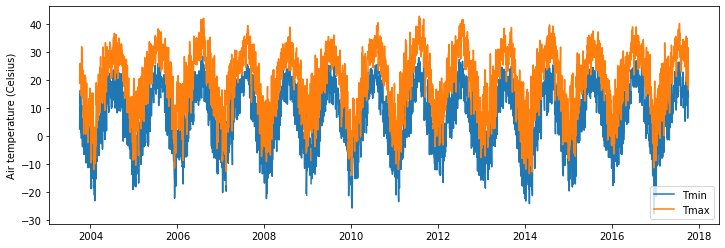

In [97]:
# Air temperature
plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], df["T_DAILY_MIN"], label="Tmin")
plt.plot(df["LST_DATE"], df["T_DAILY_MAX"], label="Tmax")
plt.ylabel("Air temperature (Celsius)")
plt.legend()
plt.show()


## Compute annual average air temperature

To establish some predictive power in aour weather generator we need to extract the deterministic and stochastic components of the signal. 

In [103]:
# Get annual average Tmin and Tmax
T_avg_avg = df["T_DAILY_AVG"].median()
T_min_avg = df["T_DAILY_MIN"].median()
T_max_avg = df["T_DAILY_MAX"].median()

print("Tavg_avg:",T_avg_avg)
print("Tmin_avg:",T_min_avg)
print("Tmax_avg:",T_max_avg)


Tavg_avg: 14.2
Tmin_avg: 7.1
Tmax_avg: 21.3


In [15]:
# Difference between Tmax and Tmin
T_diff = df["T_DAILY_MAX"] - df["T_DAILY_MIN"]


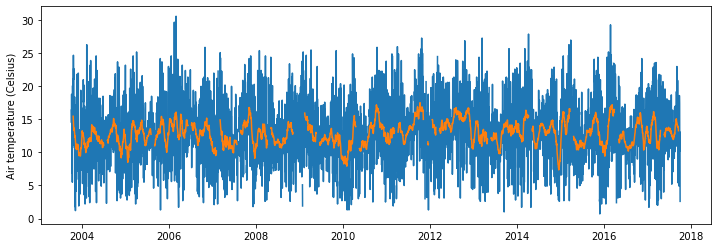

In [19]:
plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], T_diff)
plt.plot(df["LST_DATE"], T_diff.rolling(window=30, center=True).mean())
plt.ylabel("Air temperature (Celsius)")
plt.show()


Investigate if there is autocorrelation between consecutive differences in Tmax and Tmin. If there is poor correlation, then that is a sign of randomness. If the differences are correlated, then we might need to account for this trend to better mimic the natural patterns.


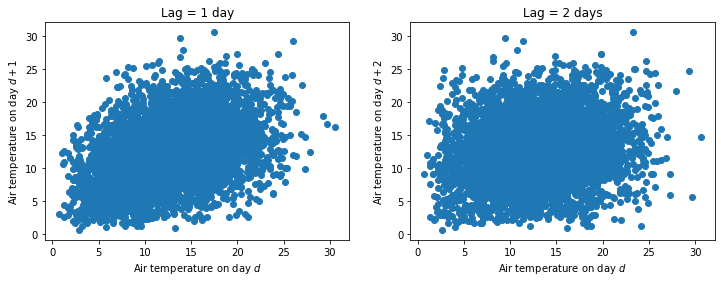

In [66]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("Lag = 1 day")
plt.scatter(T_diff[0:-1],T_diff[1:])
plt.xlabel("Air temperature on day $d$")
plt.ylabel("Air temperature on day $d+1$")

plt.subplot(1,2,2)
plt.title("Lag = 2 days")
plt.scatter(T_diff[0:-2],T_diff[2:])
plt.xlabel("Air temperature on day $d$")
plt.ylabel("Air temperature on day $d+2$")
plt.show()


With a lag of 1 day we see a some positive trend, but it seems weak and probably not worth considering in our trivial example. This is even more clear with a lag of 2 days. This trends mean that the difference between Tmax and Tmin in one day are poorly correlated with the difference in Tmax and Tmin the next day. In principle this help us support our choice of modelling these fluctuations using a random process. 

>Note that the differences may be related to another variable, such as rainfall and solar radiation. 

Let's check out the histogram so that we can have a sound idea of the type of random process that we need to simulate.


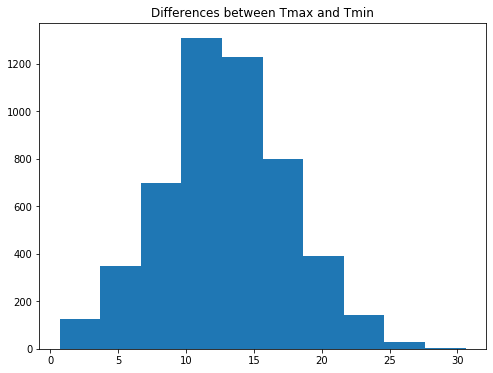

In [37]:
# Histogram
plt.figure(figsize=(8,6))
plt.title("Differences between Tmax and Tmin")
plt.hist(T_diff)
plt.show()


In [38]:
# Compute normal distribution parameters
T_diff_mean = T_diff.mean()
T_diff_std = T_diff.std()

print(T_diff_mean, 'Celsius')
print(T_diff_std, 'Celsius')

12.901122931442101 Celsius
4.660808691099936 Celsius


## Compute timing of minimum and maximum temperatures

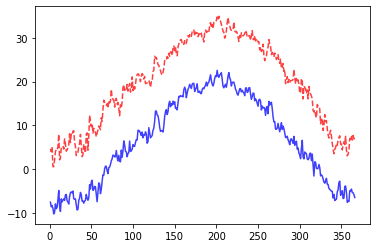

In [65]:
# Generate smooth
df_grouped = df.groupby(["DOY"]).mean()

plt.plot(df_grouped.index, df_grouped["T_DAILY_MIN"], '-b',  alpha=0.75, label='Tmin')
plt.plot(df_grouped.index, df_grouped["T_DAILY_MAX"], '--r', alpha=0.75, label='Tax')
plt.show()


In [69]:
# Occurrence of maximum values (on average)
print(df_grouped["T_DAILY_MIN"].rolling(window=15, center=True).mean().idxmax())
print(df_grouped["T_DAILY_MAX"].rolling(window=15, center=True).mean().idxmax())


199
199


In [70]:
# Occurrence of minimum values (on average)
print(df_grouped["T_DAILY_MIN"].rolling(window=15, center=True).mean().idxmin())
print(df_grouped["T_DAILY_MAX"].rolling(window=15, center=True).mean().idxmin())


8
8


## Compute annual thermal amplitude

To compute the amplitude we will first smooth the air temperature signal using a centered moving average. THen we have two options, computing the amplitude from records of 
Here there are two options: 1) computing the amplitude using a smoothed version of Tmin and Tmax, or 2) simply computing the average amplitude of each day on record. Let's try both and see if there is any difference. We should favor the easiest approach.


For the first approach, we will estimate the annual average thermal amplitude by first computing the amplitude for each day of the year, and then calculate the annual average. This approach removes some noise before calcualting the amplitude.


In [93]:
# Option 1: Compute average amplitude by using de-noised signal
T_max_max = df_grouped["T_DAILY_MAX"].rolling(window=15, center=True).mean().max()
T_max_min = df_grouped["T_DAILY_MAX"].rolling(window=15, center=True).mean().min()
amplitude = ((T_max_max - T_max_min)/2)
print(amplitude)


14.834194139194146


In [95]:
# Option 2: Compute amplitude as the average amplitude of all observations
T_min_max = df_grouped["T_DAILY_MIN"].rolling(window=15, center=True).mean().max()
T_min_min = df_grouped["T_DAILY_MIN"].rolling(window=15, center=True).mean().min()
amplitude = ((T_min_max - T_min_min)/2)
print(amplitude)

14.545347985347988


3.8430036630036635

The two different approaches are remarkably similar. At least for the current location, more complicated does not necessarily mean more accurate.


## Build model for air temperature

A sinusoidal model is probably adequate to mimic the seasonal dynamics. This is the deterministic part of our model. The difference between our model and observations we will be attributed to random noise, or to more complicated relationships that go beyond the scope of this exercise.

$$ T(t) = T_{avg} + A \; sin \Bigg[2 \pi (\frac{DOY}{365} + \phi + \frac{\pi}{2}) \Bigg] + \epsilon $$


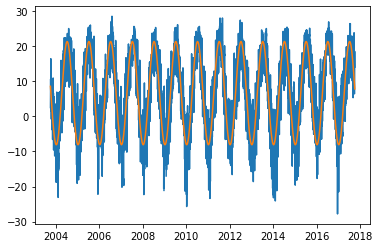

In [96]:
# Get amplitude of the sinusoidal pattern
dates = df["LST_DATE"]

# Get day of the year for each input date
doy = df["LST_DATE"].dt.dayofyear

T_avg = 6.6
A = 14.7
phase = 8
T = T_avg + A * np.sin(2*np.pi*( (doy-phase)/365) - np.pi/2)

plt.plot(df["LST_DATE"], df["T_DAILY_MIN"], label="Tmin")
plt.plot(dates,T)
plt.show()

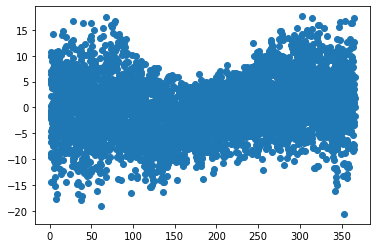

In [105]:
# Compute noise
plt.scatter(doy,df["T_DAILY_MIN"] - T)
plt.show()

In [ ]:
# Noise changes as a function of the day of the year.
# Need to improve and simplify whole temperature approach.


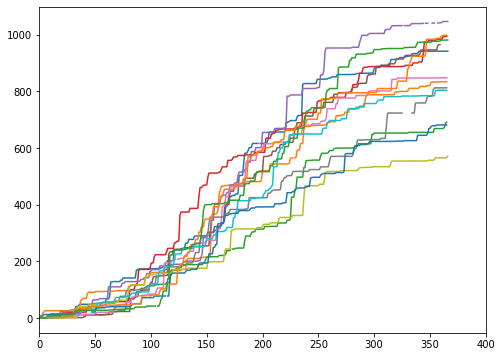

In [152]:
# Observe trends in precipitation data (2004 to 2016)
plt.figure(figsize=(8,6))
plt.xlim(0,400)
for year in range(2004,2017):
    idx_year = df["YEAR"] == year
    cdf = df["P_DAILY_CALC"][idx_year].cumsum()
    plt.plot(range(1,len(cdf)+1),cdf)
    #plt.annotate(str(year), xy=(370,cdf.values[-1]))
    

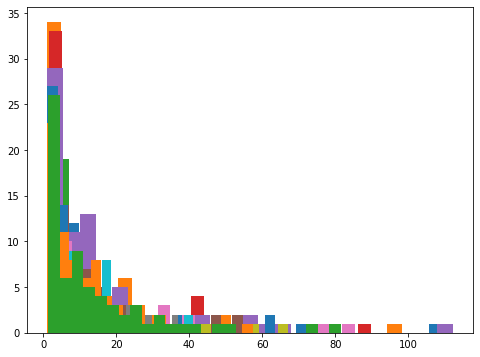

In [173]:
# Observe histograms of precipitation

plt.figure(figsize=(8,6))
for year in range(2004,2017):
    idx_year = df["YEAR"] == year
    rainfall_year = df["P_DAILY_CALC"][idx_year]
    rainfall_year = rainfall_year[rainfall_year > 1]
    plt.hist(rainfall_year, bins=25)


## Solar radiation

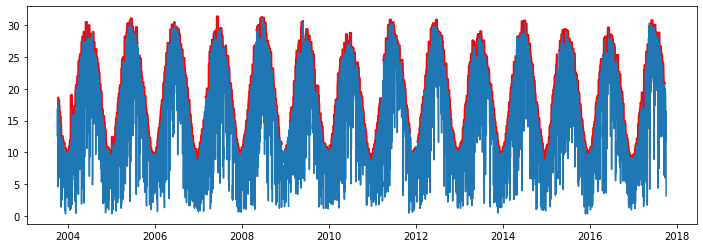

In [118]:
# Observe trends in solar radiation data
plt.figure(figsize=(12,4))
plt.plot(df["LST_DATE"], df["SOLARAD_DAILY"])
plt.plot(df["LST_DATE"], df["SOLARAD_DAILY"].rolling(window=15, center=True).max(), '-r')
plt.show()


In [133]:
# Compute maximum solar radiation (proxy for ideal, non-cloudy conditions)
solar_rad_max = df_grouped["SOLARAD_DAILY"].rolling(window=15, center=True).quantile(0.95)


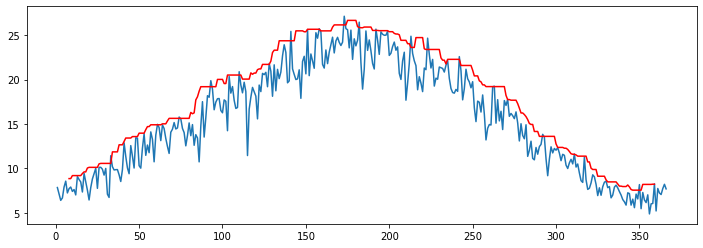

In [134]:
plt.figure(figsize=(12,4))
plt.plot(df_grouped.index, df_grouped["SOLARAD_DAILY"])
plt.plot(df_grouped.index, solar_rad_max, '-r')

plt.show()

## References

Intergernmental Panel on Climate Change Data Distribution Centre: https://www.ipcc-data.org/guidelines/pages/weather_generators.html

Jones, P., Harpham, C., Kilsby, C., Glenis, V. and Burton, A., 2010. UK Climate Projections science report: Projections of future daily climate for the UK from the Weather Generator.

Kilsby, C.G., Jones, P.D., Burton, A., Ford, A.C., Fowler, H.J., Harpham, C., James, P., Smith, A. and Wilby, R.L., 2007. A daily weather generator for use in climate change studies. Environmental Modelling & Software, 22(12), pp.1705-1719.

Richardson, C.W. and Wright, D.A., 1984. WGEN: A model for generating daily weather variables.